In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.signal as sg
import scipy.ndimage as img

from functions.latex import set_size
from skimage import measure
from cartopy.util import add_cyclic_point

#import cmocean



datadir = "../data/"
figdir = "../figures/"

g = 9.81
R = 6371e3
omega = 7.29e-5

In [ ]:
def get_region_coords(region_name="arctic_ocean", xy=False):
    region_dict = {
        "arctic_ocean": {False: [-180, 180, 60, 90], True: [65, 185, 0, 215]},
        "canada_basin": {False: [-180, -95, 70, 85], True: [70, 130, 135, 205]},
        "amerasian_basin": {False: [], True: [70, 160, 120, 205]},
        "eurasian_basin": {False: [-180, 180, 78, 90], True: [110, 180, 80, 170]},
        "makarov_basin": {False: [-180, 180, 78, 90], True: [110, 155, 120, 190]},
        "greenland_basin": {False: [-15, 15, 72, 80], True: [110, 145, 50, 85]},
        "lofoten_basin": {False: [-5, 13.5, 68, 73], True: [125, 145, 30, 55]},
        "norwegian_basin": {False: [-8, 3, 63, 71], True: [115, 135, 15, 45]},
        "norwegian_seas": {False: [-15, 15, 62, 73], True: [115, 155, 10, 55]},
        "nordic_seas": {False: [-15, 15, 62, 73], True: [75, 175, 0, 90]},
    }
    
    if region_name not in region_dict:
        raise ValueError("Undefined region, please check spelling.")
    
    return region_dict[region_name][xy]

def create_map(region_name, region, subplots=(1, 1), draw_gridlabels=True, **kwargs):
    #if region_name == "arctic_mediterranean":
    if (region[0] + region[1] == 0) and region[-1] == 90:
        proj = ccrs.NorthPolarStereo()
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        shape = mpath.Path(verts * radius + center)
    else:
        proj = ccrs.LambertConformal(central_longitude=(region[0] + region[1])/2,
                                     central_latitude=(region[2] + region[3])/2
                                    )
        n = 20
        shape = mpath.Path(
            list(zip(np.linspace(region[0], region[1], n), np.full(n, region[3]))) + \
            list(zip(np.full(n, region[1]), np.linspace(region[3], region[2], n))) + \
            list(zip(np.linspace(region[1], region[0], n), np.full(n, region[2]))) + \
            list(zip(np.full(n, region[0]), np.linspace(region[2], region[3], n)))
        )
    fig, axes = plt.subplots(subplots[0], subplots[1],
                             subplot_kw={"projection" : proj},
                             **kwargs
                            )
    if np.sum(subplots) == 2:
        #if region_name == "arctic_mediterranean":
        if (region[0] + region[1] == 0) and region[-1] == 90:
            transform = axes.transAxes
            crs = ccrs.PlateCarree()
        else:
            transform = ccrs.PlateCarree()
            crs = None
        axes.set_extent(region, crs=ccrs.PlateCarree())
        axes.set_boundary(shape, transform=transform)
        axes.coastlines()
        """
        axes.gridlines(draw_labels=draw_gridlabels,
                       rotate_labels=False,
                       x_inline=False,
                       y_inline=False
                      )
        """
        axes.add_feature(cfeature.LAND, color="grey", zorder=100)
    else:
        for ax in axes.flatten():
            #if region_name == "arctic_mediterranean":
            if (region[0] + region[1] == 0) and region[-1] == 90:
                transform = ax.transAxes
                crs = ccrs.PlateCarree()
            else:
                transform = ccrs.PlateCarree()
                crs = None
            ax.set_extent(region, crs=crs)
            ax.set_boundary(shape, transform=transform)
            ax.coastlines()
            """
            ax.gridlines(draw_labels=draw_gridlabels,
                         rotate_labels=False,
                         x_inline=False,
                         y_inline=False
                        )
            """
            ax.add_feature(cfeature.LAND, color="grey", zorder=100)
    return fig, axes

def plot_loghist(ax, x, bins, **kwargs):
    hist, bins = np.histogram(x,
                              bins=bins,
                              range=(np.nanmin(x), np.nanmax(x))
                             )
    logbins = np.logspace(np.log10(bins.min()), np.log10(bins.max()),len(bins))
    ax.hist(x, bins=logbins, **kwargs)
    ax.set_xscale('log')
    return ax

In [4]:
ds = xr.open_dataset(datadir + "hydrography_woa.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 1440, depth: 102)
Coordinates:
  * lat      (lat) float32 60.12 60.38 60.62 60.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Data variables:
    ct       (depth, lat, lon) float64 ...
    sa       (depth, lat, lon) float32 ...
    t_dd     (depth, lat, lon) float64 ...
    s_dd     (depth, lat, lon) float64 ...
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [ ]:
ds_sel = ds.sum(dim="depth", skipna=True)
ds_sel

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 1440)
Coordinates:
  * lat      (lat) float32 60.12 60.38 60.62 60.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    ct       (lat, lon) float64 198.8 180.2 159.4 133.2 ... -52.41 -52.41 -52.41
    sa       (lat, lon) float32 2.365e+03 2.019e+03 ... 3.02e+03 3.02e+03
    t_dd     (lat, lon) float64 101.0 158.0 215.0 61.0 56.0 ... 0.0 0.0 0.0 0.0
    s_dd     (lat, lon) float64 66.0 101.0 167.0 64.0 30.0 ... 0.0 0.0 0.0 0.0

In [ ]:
region_name = "arctic_ocean"
region = get_region_coords(region_name)
region

[-180, 180, 60, 90]

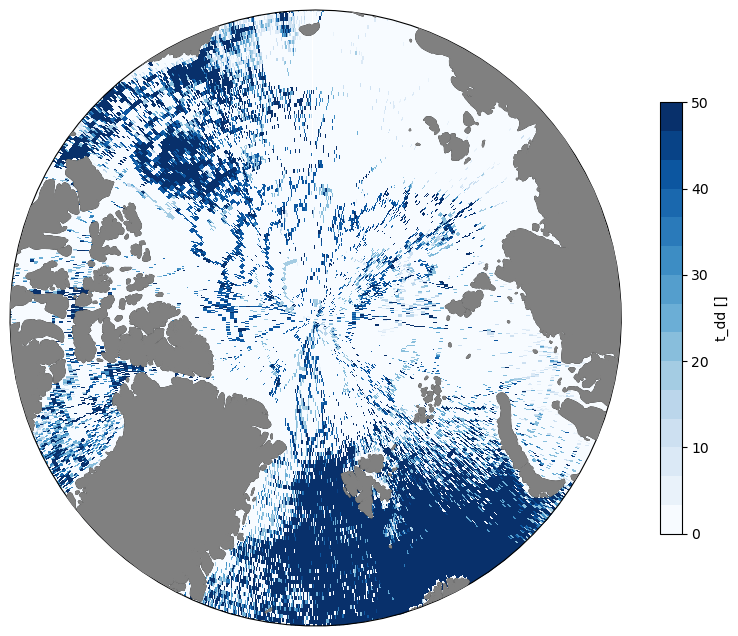

In [35]:
fig, ax = create_map(region_name, region,
                     figsize=(10, 8)
                    )
cmap = plt.get_cmap('Blues', 15)

c = ax.pcolormesh(ds_sel.lon, ds_sel.lat, ds_sel.t_dd.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                transform=ccrs.PlateCarree(),
                vmin=0,
                  vmax=50,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )

fig.colorbar(c,
             label="t_dd []",
             shrink=0.7
            )

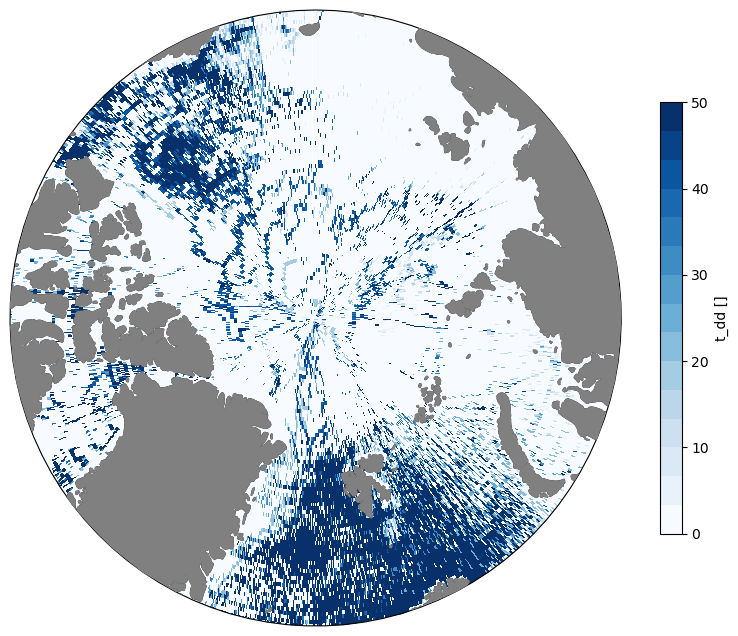

In [36]:
fig, ax = create_map(region_name, region,
                     figsize=(10, 8)
                    )
cmap = plt.get_cmap('Blues', 15)

c = ax.pcolormesh(ds_sel.lon, ds_sel.lat, ds_sel.s_dd.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                transform=ccrs.PlateCarree(),
                vmin=0,
                  vmax=50,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )

fig.colorbar(c,
             label="t_dd []",
             shrink=0.7
            )

0.0
0.0
4300.0


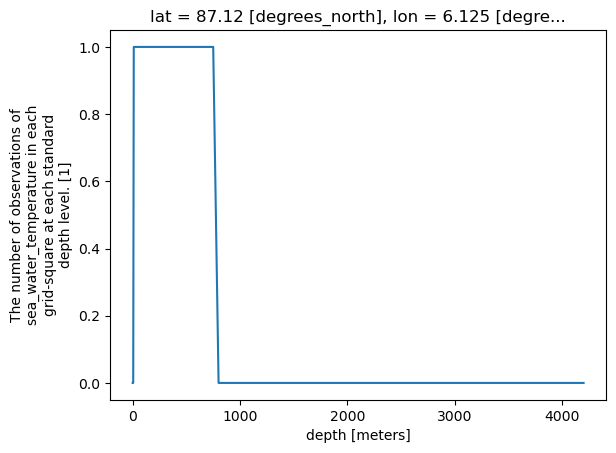

In [ ]:
lat_sel, lon_sel = 87, 6
var_sel = ds.t_dd.sel(lat=lat_sel, lon=lon_sel, method="nearest")
var_sel.plot()
print(var_sel.sel(depth=0, method="nearest").values)
print(var_sel.idxmin().values)
print(var_sel.isnull().idxmax().values)

In [85]:
lat_sel, lon_sel = 80, 5
var_sel = ds.t_dd.sel(lat=lat_sel, lon=lon_sel, method="nearest")
if var_sel.min() < 1e-4:
    depth_obs = var_sel.idxmin().values
    depth = var_sel.isnull().idxmax().values
print(f"depth_obs = {depth_obs}")
print(f"depth = {depth}")
D = (depth_obs + depth)/(2*depth)
print(D)

depth_obs = 800.0
depth = 950.0
0.9210526315789473


In [6]:
lat_sel, lon_sel = 80, 6
var_sel = ds.t_dd.sel(lat=lat_sel, lon=lon_sel, method="nearest")
if var_sel.min() < 1e-4:
    depth = var_sel.isnull().idxmax().values
    depth_obs = var_sel.idxmin().values
else:
    depth = var_sel.isnull().idxmax().values
    depth_obs = depth
print(f"depth_obs = {depth_obs}")
print(f"depth = {depth}")
D = (depth_obs + depth)/(2*depth)
print(D)

depth_obs = 850.0
depth = 850.0
1.0


In [4]:
D_array = np.zeros((len(ds.lat), len(ds.lon)))
for i, lat_sel in enumerate(ds.lat):
    for j, lon_sel in enumerate(ds.lon):
        var_sel = ds.t_dd.sel(lat=lat_sel, lon=lon_sel, method="nearest")
        depth = var_sel.isnull().idxmax()
        if depth > 0:
            if var_sel.min() < 1e-4:
                depth_obs = var_sel.idxmin()
            else:
                depth_obs = depth
            D = 1 - (depth - depth_obs)/depth
        else:
            D = np.nan
        D_array[i, j] = D

In [ ]:
ds_D = xr.DataArray(D_array, 
                    coords={"lat": ds.lat, "lon": ds.lon}, 
                    dims=["lat", "lon"],
                    name="D"
                   )
ds_D

<xarray.DataArray (lat: 120, lon: 1440)>
array([[0.83333333, 0.9117647 , 1.        , ..., 0.76923077, 0.41666669,
        0.41666669],
       [0.59999999, 0.86206897, 0.94444444, ..., 0.18269229, 0.7352941 ,
        0.        ],
       [1.        , 0.27272725, 1.        , ..., 0.52000001, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * lat      (lat) float32 60.12 60.38 60.62 60.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

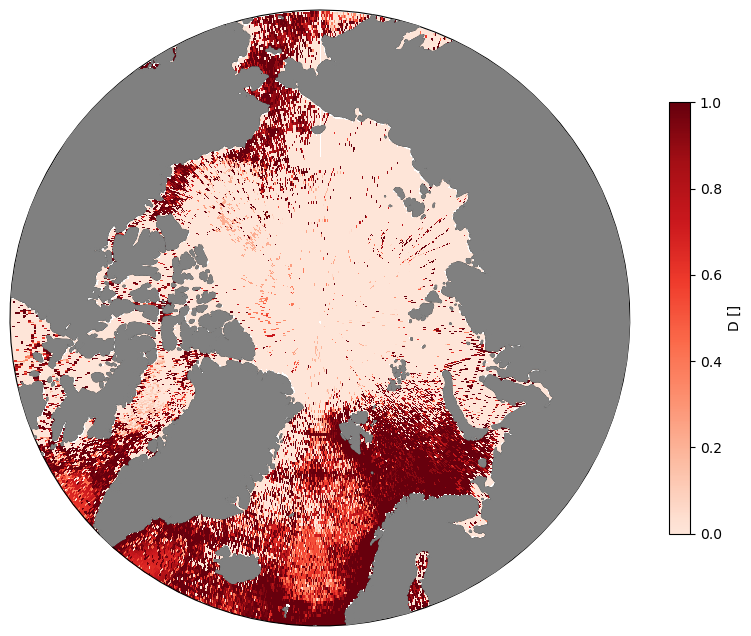

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds')
cmap = truncate_colormap(cmap, minval=0.1, maxval=1.0)

fig, ax = create_map(region_name, region,
                     figsize=(10, 8)
                    )

c = ax.pcolormesh(ds_D.lon, ds_D.lat, ds_D.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=1,
                  cmap=cmap
                  )

fig.colorbar(c,
             label="D []",
             shrink=0.7
            )

In [ ]:
depth_field = ds.t_dd.isnull().idxmax(dim="depth")
depth_field

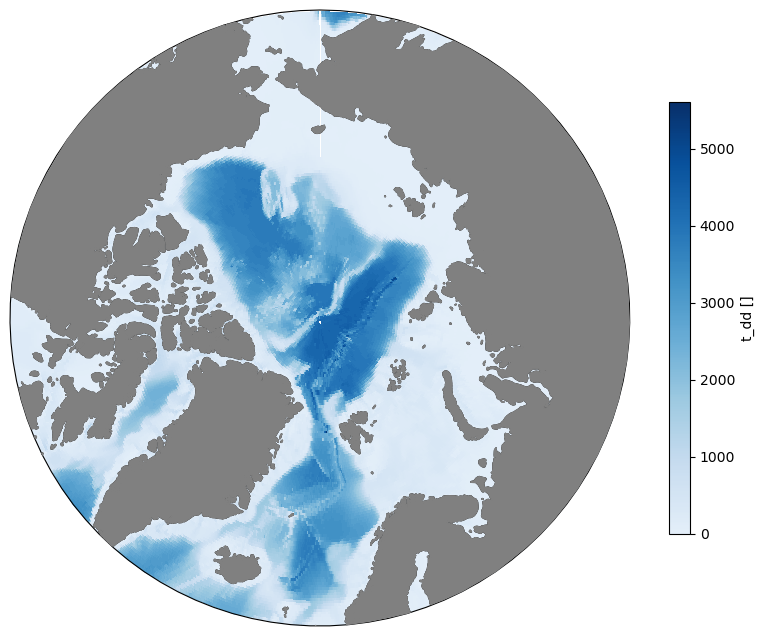

In [105]:
fig, ax = create_map(region_name, region,
                     figsize=(10, 8)
                    )

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Blues')
cmap = truncate_colormap(cmap, minval=0.1, maxval=1.0)

c = ax.pcolormesh(depth_field.lon, depth_field.lat, depth_field.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                transform=ccrs.PlateCarree(),
                vmin=0,
                  vmax=5600,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )

fig.colorbar(c,
             label="t_dd []",
             shrink=0.7
            )

In [33]:
ds.t_dd.sum(dim="depth").where(depth_field == ds.isel(depth=-6).depth).max()

<xarray.DataArray 't_dd' ()>
array(31.)
Coordinates:
    depth    float32 5e+03

In [7]:
n_array = np.zeros(len(ds.depth))
for i, d in enumerate(ds.depth):
    val = ds.t_dd.where(depth_field == ds.isel(depth=i).depth).sum(dim="depth").max()
    if ~np.isnan(val) and val > 0:
        n_array[i] = val
    else:
        n_array[i] = np.nan
ds_n = xr.DataArray(n_array, 
                    coords={"depth" : ds.depth}, 
                    dims=["depth"]
                   )
ds_n

<xarray.DataArray (depth: 102)>
array([ 1015.,    41.,   344.,   472.,   699.,   663.,   176.,   646.,
         659.,   520.,   540.,  1544.,  1519.,  1037.,  1879.,  1158.,
        4507.,  1814.,  1964.,  2272.,  1461.,  3098.,  3794.,  6178.,
        5948.,  4019.,  8670.,  4419.,  8698.,  5004.,  2894.,  6366.,
        4443.,  5473.,  4294.,  5230.,  6924.,  9782.,  4108.,  4914.,
       10219.,  3859.,  5841.,  9308.,  6980.,  6421.,  2022.,  5881.,
        9733.,  3728.,  4472.,  7129.,  2148.,  2996.,  1498.,  4713.,
        5596.,  1318.,  1020.,  4413.,  2039.,  8981.,   938.,  7768.,
        1910.,  4457.,  1782.,  6896.,  1219.,  1372.,  1622.,  3976.,
        2686.,  2920.,  2623.,  6258.,  6094.,  2069.,  1544.,  6169.,
        8253.,   731.,  1364.,  2267.,  2360.,   522.,   633.,   345.,
         251.,   178.,   142.,   160.,   281.,    nan,   471.,    nan,
          31.,    nan,    nan,    nan,   745.,    nan])
Coordinates:
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03

In [ ]:
nobs = ds.t_dd
da_list = []
for i, d in enumerate(nobs.depth):
    da = xr.where(depth_field == d, nobs/ds_n.isel(depth=i), 0).sum(dim="depth", skipna=True)
    da_list.append(da)
da_nobs = xr.DataArray(np.sum(da_list, axis=0), 
                    coords={"lat": ds.lat, "lon": ds.lon}, 
                    dims=["lat", "lon"],
                    name="N"
                   )
da_nobs

<xarray.DataArray 'N' (lat: 120, lon: 1440)>
array([[0.0622688 , 0.07748897, 0.03015851, ..., 0.05510052, 0.02836005,
        0.04377312],
       [0.01102327, 0.01506471, 0.04154728, ..., 0.01303053, 0.07209416,
        0.        ],
       [0.04157725, 0.00811672, 0.03052503, ..., 0.01655211, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * lat      (lat) float32 60.12 60.38 60.62 60.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [29]:
da_nobs.max()

<xarray.DataArray 'N' ()>
array(1.)

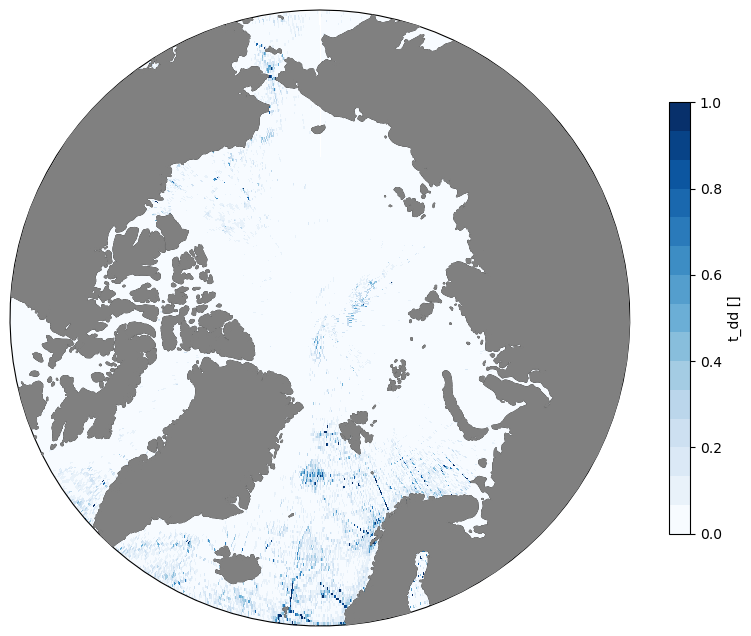

In [ ]:
fig, ax = create_map(region_name, region,
                     figsize=(10, 8)
                    )
cmap = plt.get_cmap('Blues', 15)

c = ax.pcolormesh(da_nobs.lon, da_nobs.lat, da_nobs.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=1,
                  cmap=cmap
                  )

fig.colorbar(c,
             label="t_dd []",
             shrink=0.7
            )

In [9]:
ds_D = xr.open_dataarray(datadir + "depth_ratio.nc")
ds_index = (da_nobs.where(da_nobs > 0) + ds_D)/2
ds_index.name = "ND"
ds_index

<xarray.DataArray 'ND' (lat: 120, lon: 1440)>
array([[0.44780107, 0.49462683, 0.51507925, ..., 0.41216564, 0.22251337,
        0.2302199 ],
       [0.30551163, 0.43856684, 0.49299586, ..., 0.09786141, 0.40369413,
               nan],
       [0.52078863, 0.14042198, 0.51526252, ..., 0.26827606,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float32 60.12 60.38 60.62 60.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [49]:
ds_index.max()

<xarray.DataArray 'ND' ()>
array(1.)

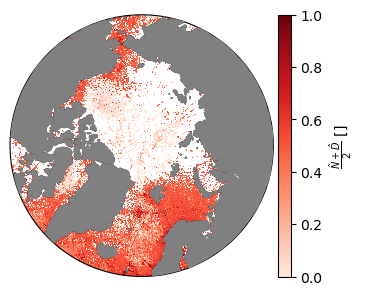

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds')
cmap = truncate_colormap(cmap, minval=0.1, maxval=1.0)

fig, ax = create_map(region_name, region,
                     figsize=set_size(width="AGU")
                    )

c = ax.pcolormesh(ds_index.lon, ds_index.lat, ds_index.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                transform=ccrs.PlateCarree(),
                vmin=0,
                  vmax=1,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )

fig.colorbar(c,
             label=r"$\frac{\hat{N} + \hat{D}}{2}$ []",
             #shrink=0.8,
             pad=0.01
            )
fig.savefig(figdir + "data_coverage.png", format="png", dpi=300, bbox_inches="tight")

In [44]:
ds_sel.t_dd.to_netcdf(datadir + "nobservations_woa.nc")